In [61]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [62]:
base = pd.read_csv('/home/pasoneto/Documents/github/doc_suomi/data/treated_data/upsampled_binded.csv')
base = base.dropna()

nalbums_treino = 3000
nalbums_teste = (len(base)/16)-nalbums_treino
, 
treino = np.array(base["0"][0:(nalbums_treino*16)-1]).reshape(1, -1)
teste = np.array(base["0"][len(treino)+1:]).reshape(1, -1)
treino = treino[0]
teste = teste[0]
# Verificando
nalbums_treino + nalbums_teste == len(base)/16

True

In [63]:
# Sampling
previsores_treino = [treino[i:i+4] for i in range(len(treino)-4)]
previsores_teste = [teste[i:i+4] for i in range(len(teste)-4)]

real_treino = [treino[i] for i in range(4,len(treino))]
real_teste =  [teste[i]  for i in range(4,len(teste))]


In [64]:
############## TREINO
p_treino = []
for i in range(0, len(previsores_treino)-16, 16):
    p_treino.append(previsores_treino[i:i+11])

p_treino = np.concatenate(p_treino).ravel().tolist()
p_treino = np.reshape(p_treino, (int(len(p_treino)/4), 4, 1))

############## TESTE
p_teste = []
for i in range(0, len(previsores_teste)-16, 16):
    p_teste.append(previsores_teste[i:i+11])

p_teste = np.concatenate(p_teste).ravel().tolist()
p_teste = np.reshape(p_teste, (int(len(p_teste)/4), 4, 1))


############## REAL TREINO
r_treino = []
for i in range(0, len(real_treino)-16, 16):
    r_treino.append(real_treino[i:i+11])

r_treino = np.concatenate(r_treino).ravel().tolist()
r_treino = np.reshape(r_treino, (len(r_treino), 1, 1))


# ############## REAL TESTE
r_teste = []
for i in range(0, len(real_teste)-16, 16):
    r_teste.append(real_teste[i:i+11])

r_teste = np.concatenate(r_teste).ravel().tolist()
r_teste = np.reshape(r_teste, (len(r_teste), 1, 1))

In [65]:
# Verificando
for i in range(10):
        print(previsores_treino[i], real_treino[i])

[-1.0938947  -0.29651618 -0.29651618 -0.43965068] -0.22494891
[-0.29651618 -0.29651618 -0.43965068 -0.22494891] -0.22494891
[-0.29651618 -0.43965068 -0.22494891 -0.22494891] 1.9638164
[-0.43965068 -0.22494891 -0.22494891  1.9638164 ] 1.6715834
[-0.22494891 -0.22494891  1.9638164   1.6715834 ] 1.6715834
[-0.22494891  1.9638164   1.6715834   1.6715834 ] 0.17463495
[1.9638164  1.6715834  1.6715834  0.17463495] -0.48736218
[ 1.6715834   1.6715834   0.17463495 -0.48736218] -0.48736218
[ 1.6715834   0.17463495 -0.48736218 -0.48736218] -1.0086104
[ 0.17463495 -0.48736218 -0.48736218 -1.0086104 ] 0.3714449


In [76]:
p_treino.shape

(32989, 4, 1)

In [77]:
# Definindo modelo
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (p_treino.shape[1], 1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 20, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 20, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 20))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1, activation = 'linear'))

regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', 
                  metrics = ['mean_absolute_error'])

es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1)
rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose = 1)
mcp = ModelCheckpoint(filepath = 'pesos.h5', monitor = 'loss', 
                      save_best_only = True, verbose = 1)

In [120]:
# Fitando modelo
regressor.fit(p_treino, r_treino, epochs = 100, batch_size = 32)

Epoch 1/100
1031/1031 [==============================] - 7s 7ms/step - loss: 0.7192 - mean_absolute_error: 0.6774
Epoch 2/100
1031/1031 [==============================] - 8s 7ms/step - loss: 0.7206 - mean_absolute_error: 0.6784
Epoch 3/100
1031/1031 [==============================] - 8s 7ms/step - loss: 0.7187 - mean_absolute_error: 0.6770
Epoch 4/100
1031/1031 [==============================] - 8s 8ms/step - loss: 0.7203 - mean_absolute_error: 0.6787
Epoch 5/100
1031/1031 [==============================] - 7s 7ms/step - loss: 0.7233 - mean_absolute_error: 0.6792
Epoch 6/100
1031/1031 [==============================] - 8s 8ms/step - loss: 0.7194 - mean_absolute_error: 0.6766
Epoch 7/100
1031/1031 [==============================] - 7s 7ms/step - loss: 0.7247 - mean_absolute_error: 0.6796
Epoch 8/100
1031/1031 [==============================] - 7s 7ms/step - loss: 0.7191 - mean_absolute_error: 0.6770
Epoch 9/100
1031/1031 [==============================] - 7s 7ms/step - loss: 0.7171 - me

1031/1031 [==============================] - 6s 6ms/step - loss: 0.7163 - mean_absolute_error: 0.6758
Epoch 73/100
1031/1031 [==============================] - 7s 7ms/step - loss: 0.7157 - mean_absolute_error: 0.6743
Epoch 74/100
1031/1031 [==============================] - 7s 7ms/step - loss: 0.7140 - mean_absolute_error: 0.6736
Epoch 75/100
1031/1031 [==============================] - 7s 7ms/step - loss: 0.7232 - mean_absolute_error: 0.6788
Epoch 76/100
1031/1031 [==============================] - 7s 7ms/step - loss: 0.7176 - mean_absolute_error: 0.6749
Epoch 77/100
1031/1031 [==============================] - 7s 7ms/step - loss: 0.7143 - mean_absolute_error: 0.6735
Epoch 78/100
1031/1031 [==============================] - 7s 7ms/step - loss: 0.7167 - mean_absolute_error: 0.6753
Epoch 79/100
1031/1031 [==============================] - 7s 7ms/step - loss: 0.7180 - mean_absolute_error: 0.6767
Epoch 80/100
1031/1031 [==============================] - 7s 7ms/step - loss: 0.7137 - mean_a

In [125]:
previsoes = regressor.predict(p_teste)

RMSE model: 0.8660625429718372
RMSE baseline: 1.0522704065849693


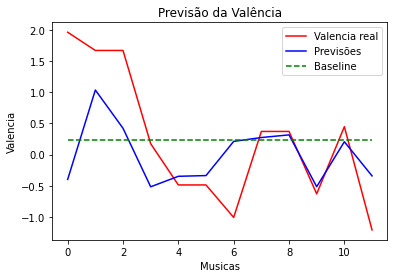

RMSE model: 0.8827401539977838
RMSE baseline: 1.234014542596383


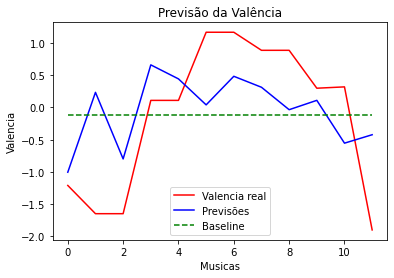

RMSE model: 0.49076515468154
RMSE baseline: 0.6390946715005902


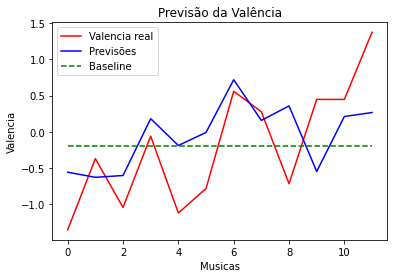

RMSE model: 0.8302379520255353
RMSE baseline: 1.2872431649708165


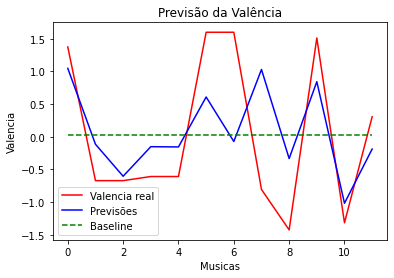

RMSE model: 0.5870834110423252
RMSE baseline: 0.9593510045026195


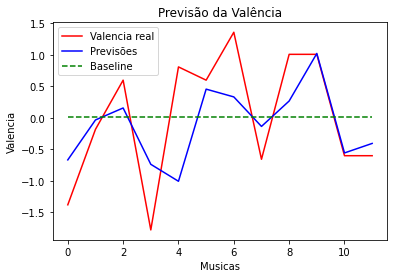

RMSE model: 0.396373829989908
RMSE baseline: 0.9557364784999692


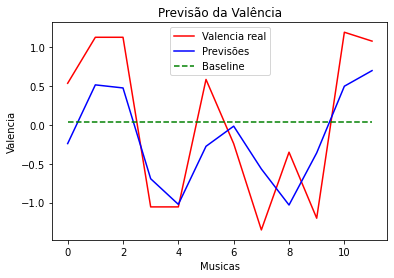

RMSE model: 0.6432029763137467
RMSE baseline: 0.8313918995265398


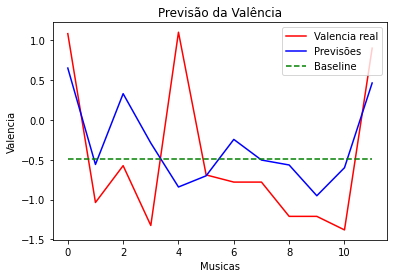

RMSE model: 0.48790346433308845
RMSE baseline: 1.0966763678925604


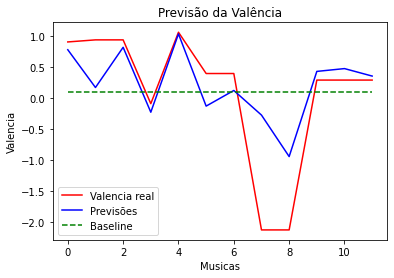

RMSE model: 0.599748592769519
RMSE baseline: 0.7429080882834574


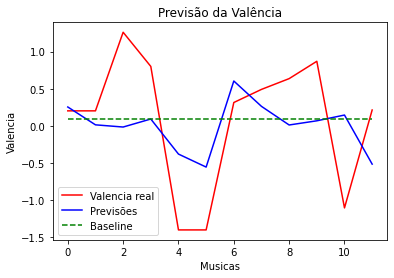

RMSE model: 0.6615745602603408
RMSE baseline: 0.8549340962648965


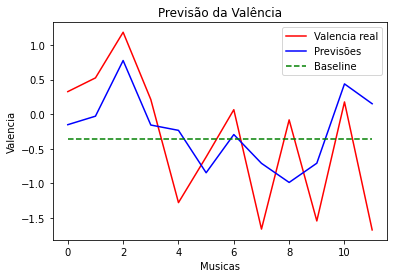

In [139]:
for i in range(0, 120, 12):
    real = np.concatenate(r_teste).ravel().tolist()[i:i+12]
    previsao = previsoes[i:i+12]
    baseline = [np.mean(real) for i in range(12)]
    plt.plot(real, color = 'red', label = 'Valencia real')
    plt.plot(previsao, color = 'blue', label = 'Previsões')
    plt.plot(baseline, 'r--', color = 'green', label = 'Baseline')
    plt.title('Previsão da Valência')
    plt.xlabel('Musicas')
    plt.ylabel('Valencia')
    print("RMSE model:"   , mean_squared_error(real, previsao))
    print("RMSE baseline:", mean_squared_error(real, baseline))
    plt.legend()
    plt.show()

In [129]:
from sklearn.metrics import mean_squared_error
mean_squared_error(np.concatenate(r_teste).ravel().tolist(), previsoes)

0.8603792316891422

In [158]:
# serialize model to JSON
model_json = regressor.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
regressor.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [169]:
# load json and create model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [174]:
# evaluate loaded model on test data
loaded_model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', 
                  metrics = ['mean_absolute_error'])


In [175]:
loaded_model.evaluate(p_teste, r_teste, verbose=1)

2019/2019 [==============================] - 6s 2ms/step - loss: 0.7447 - mean_absolute_error: 0.6791


[0.8603790402412415, 0.7336291670799255]